In [6]:
from distmesh import *
from FEM_TPT import *
import numpy as np
import matplotlib.pyplot as plt
import math

In [7]:
# a = a_1 inside the circle of radius 1 and center [1.5,1.5]
# a = a_2 outside the disk
def a_func(p,a_vals):
    d = (p[0]-1.5)**2+(p[1]-1.5)**2
    if d<1:
        return a_vals[0]
    else:
        return a_vals[1]

    
# find mesh points along a vertical line
def find_vert_line_pts(pts,x,h0):
    ind = np.argwhere(np.abs((pts[:,0]-x)) < h0*1e-2)
    Nind = np.size(ind)
    ind = np.reshape(ind,(Nind,))
    return Nind,ind


# FEM solver for HW8
def FEM_hw_solver(pts,tri,D0ind,D1ind,a_vals):
    Npts = np.size(pts,axis=0)
    Ntri = np.size(tri,axis=0)
    Dir_bdry = np.hstack((D0ind,D1ind))
    free_nodes = np.setdiff1d(np.arange(0,Npts,1),Dir_bdry,assume_unique=True)

    A = csr_matrix((Npts,Npts), dtype=float).toarray()
    b = np.zeros((Npts,1))
    u = np.zeros((Npts,1))
    u[D1ind] = 1

    # stiffness matrix
    for j in range(Ntri):
        ind = tri[j,:]
        indt = np.array(ind)[:,None]
        verts = pts[ind,:] # vertices of mesh triangle
        vmid = np.sum(verts,axis=0)/3 # midpoint of mesh triangle
        A[indt,ind] = A[indt,ind] + a_func(vmid,a_vals)*stima3(verts)

    # load vector
    b = b - np.matmul(A,u)

    # solve for voltage
    free_nodes_t = np.array(free_nodes)[:,None]
    u[free_nodes] = scipy.linalg.solve(A[free_nodes_t,free_nodes],b[free_nodes])
    u = np.reshape(u,(Npts,))
    return u 

count =  200 displacement =  0.009326066406254288
count =  400 displacement =  0.006192306403077386
count =  600 displacement =  0.002327639503204724
count =  800 displacement =  0.00217014481005556
count =  1000 displacement =  0.004834354064807509


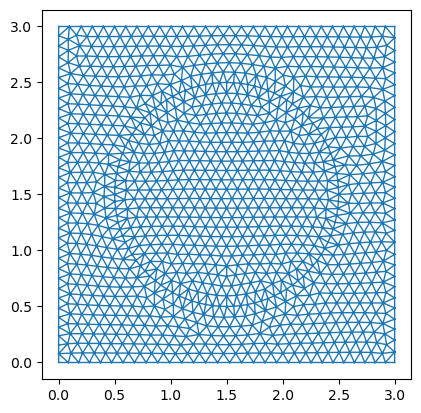

In [8]:
# mesh: square with vertices [0,0] and [3,3],
# pfix: corners of square and some points on circle of radius 1 and center [1.5,1.5]

def fd(p):
    return drectangle(p,0,3,0,3)

pfix = [[0,0], [3,0], [3,3], [0,3]]
pfix = np.append(pfix, put_pts_on_circle(1.5,1.5,1,100), axis=0)
h0 = 0.1
pts, tri = distmesh2D(fd, huniform, h0, [0, 3, 0, 3], pfix)
plt.savefig("hw8 mesh.png")

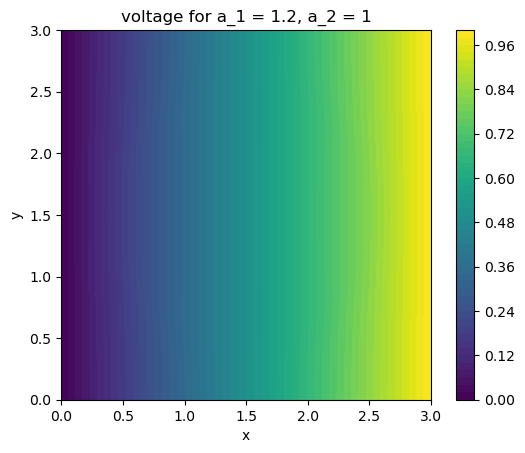

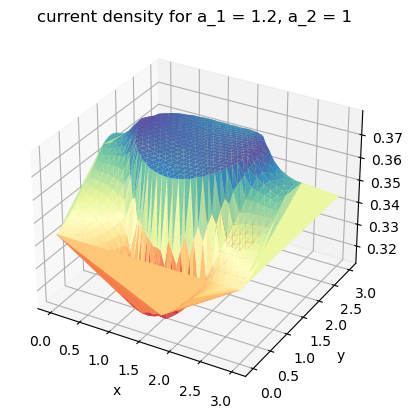

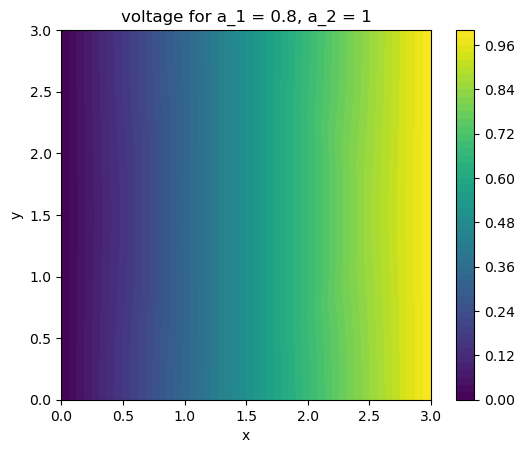

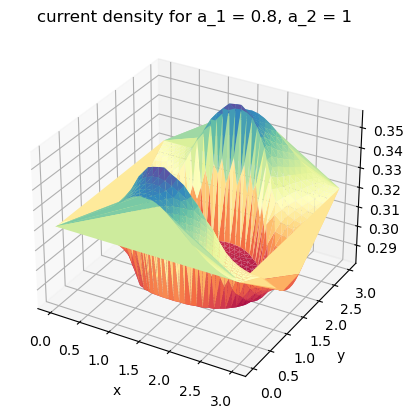

In [9]:
ND0ind, D0ind = find_vert_line_pts(pts,0,h0) # find mesh points on D_0
ND1ind, D1ind = find_vert_line_pts(pts,3,h0) # find mesh points on D_1


a_vals_list=[[1.2,1],[.8,1]]
for k in range(2):
    a_vals = a_vals_list[k]

    # find the voltage u
    u=FEM_hw_solver(pts,tri,D0ind,D1ind,a_vals)

    # visualize u
    Ncontour=50
    plt.tricontourf(pts[:,0],pts[:,1],tri,u,np.array(np.linspace(0,1,Ncontour+1)))
    plt.colorbar(orientation="vertical")
    axes=plt.gca()
    axes.set_aspect(1)
    plt.rcParams.update({'font.size': 10})
    plt.title("voltage for a_1 = {}, a_2 = {}".format(*a_vals))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.savefig('hw8 voltage {}.png'.format(k+1))
    plt.show()

    # find electric current density J = -a(x,y)\grad u
    Npts = np.size(pts,axis=0)
    Ntri = np.size(tri,axis=0)
    current = np.zeros((Ntri,2))
    Rrate=0
    for j in range(Ntri):
        ind = tri[j,:]
        verts = pts[ind,:]
        x = verts[:,0]
        y = verts[:,1]
        utri = u[ind]
        D = np.abs(np.linalg.det(np.block([np.ones((3,1)),verts])))
        g = 1/D*np.array([utri[0]*(y[1]-y[2])+utri[1]*(y[2]-y[0])+utri[2]*(y[0]-y[1]),
                          utri[0]*(x[2]-x[1])+utri[1]*(x[0]-x[2])+utri[2]*(x[1]-x[0])])
        vmid = np.sum(verts,axis=0)/3
        current[j,:] = -a_func(vmid,a_vals)*g
    current_centers = np.linalg.norm(current, axis=1)
    current_verts = np.zeros((Npts,1))
    count_tri = np.zeros((Npts,1))
    for j in range(Ntri):
        ind = tri[j,:]
        current_verts[ind] = current_verts[ind] + current_centers[j]
        count_tri[ind] = count_tri[ind] + 1
    current_verts = current_verts/count_tri

    # visualize J
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.tick_params(axis='both', labelsize=10)
    ax.plot_trisurf(pts[:,0],pts[:,1],current_verts[:,0], cmap=plt.cm.Spectral)
    plt.rcParams.update({'font.size': 10})
    plt.title("current density for a_1 = {}, a_2 = {}".format(*a_vals))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.savefig('hw8 current {}.png'.format(k+1))
    plt.show()